<a href="https://colab.research.google.com/github/Edmout/Machine-Learning-MVP/blob/main/MVP_EduardoMoutinho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Classificador de diagnóstico de câncer de mama**
**Contexto:** Temos um conjunto de dados de diagnóstico de cancer de mama em Wiscosin que representam as características dos núcleos celulares presentes em uma imagem digitalizada de um aspirado com agulha fina (PAAF) de uma massa mamária. O objetivo deste notebook é criar um modelo de visão computacional que consiga realizar a partir destas características uma classificação diagnóstica de tumores na mama entre as opções: M - Malígno ou B- Benígno.

**Estrutura:** O notebook está dividido assim:

1- Importação das bibliotecas

2 - Preparação de Dados

3 - Modelagem e treinamento

4 - Finalização do modelo

5- Simulando a aplicação do modelo em dados não vistos

**Dataset:** O dataset é originário do repositório de Machine Learning da UC Irvine para uso didático e também está disponível na biblioteca Scikit-Learn, de onde foi importado para este notebook. Os atributos são estas dez características de valor real calculadas para cada núcleo celular:

 - raio (média das distâncias do centro aos pontos do perímetro)
 - textura (desvio padrão dos valores da escala de cinza)
 - perímetro
 - área
 - suavidade (variação local nos comprimentos dos raios)
 - compacidade (perímetro^2 / área - 1,0)
 - concavidade (severidade das porções côncavas do contorno)
 - pontos côncavos (número de porções côncavas do contorno)
 - simetria
 - dimensão fractal ("aproximação do litoral" - 1)

Para mais informações sobre o dataset, veja o link a seguir: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

##  1 - Importação das bibliotecas

In [19]:
# Importando as bibliotecas necessárias para executar o notebook
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer # para importar o dataset breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # validação cruzada com estratificação
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV # para executar a otimização dos hiperparâmetros
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier # ExtraTrees, para a Importância de Atributos
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## 2 - Preparação de Dados

### *Carga do Dataset*

Realizando a carga do dataset breast_cancer e exibindo as primeiras linhas

In [20]:
# Informa a URL de importação do dataset
breast_cancer = load_breast_cancer()
dataset = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names) # conversão para dataframe
dataset['target'] = breast_cancer.target # adição da coluna target
# Mostra as primeiras linhas do dataset
dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [21]:
# Visualizando o número de linhas e colunas do dataset
dataset.shape

(569, 31)

### *Separação do dataset em conjunto de treino e conjunto de teste com holdout*

Realizando a separação em bases de treino e teste por meio do método holdout efetuando a divisão 80% base de treino e 20% base de teste

In [22]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
x_ini = array[:,0:30]
y = array[:,30]
X_train, X_test, y_train, y_test = train_test_split(x_ini, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
#scoring = 'accuracy'
#num_particoes = 10
#kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### *Realizando processo de Feature Selection*

Foram testados os métodos de seleção univariada, eliminação de recursos de atributos e importância de atributos para realizar feature selection, sendo escolhido o método de seleção univariada com redução para 4 atributos que obteve um resultado satisfatório de acurácia nos modelos testados.

In [23]:
# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=4)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(x_ini, y)

# Reduz X para os atributos selecionados
x = fit.transform(x_ini)

# Resultados
print('\nNúmero original de atributos:', x_ini.shape[1])
print('\nNúmero reduzido de atributos:', x.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset.columns[0:30])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset.columns[0:30]))


Número original de atributos: 30

Número reduzido de atributos: 4

Atributos Originais: Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

Scores dos Atributos Originais: [6.470e+02 1.181e+02 6.972e+02 5.731e+02 8.365e+01 3.132e+02 5.338e+02
 8.617e+02 6.953e+01 9.346e-02 2.688e+02 3.909e-02 2.539e+02 2.437e+02
 2.558e+00 5.325e+01 3.901e+01 1.133e+02 2.412e-02 3.468e+00 8.608e+02
 1.4

### *Realizando a validação cruzada*

Realizando a separação em 10 folds usando a validação cruzada.

In [24]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## 3 - Modelagem e Treinamento

### Criação e avaliação de modelos: linha base

Realizando a etapa de modelagem e inferência, definindo inicialmente uma semente global para essa célula de código, necessária para garantir a reprodutibilidade do código com os mesmos resultados. Como não sabemos de antemão quais algoritmos performarão bem nesse conjunto de dados, usaremos a validação cruzada para treinar e avaliar os modelos usando a métrica acurácia. Primeiramente, iremos avaliar os algoritmos Regressão Logística, KNN, Árvore de Classificação, Naive Bayes, SVM e Ensembles com a configuração padrão de hiperparâmetros da Scikit-Learn. O resultado médio da acurácia de cada modelo será impresso, bem como um gráfico boxplot sumarizando os resultados das dez execuções (correspondentes aos dez folds)

LR: 0.951546 (0.026035)
KNN: 0.922947 (0.036346)
CART: 0.931981 (0.038351)
NB: 0.934058 (0.027738)
SVM: 0.898696 (0.041344)
Bagging: 0.966908 (0.030104)
RF: 0.967005 (0.036045)
ET: 0.971401 (0.027964)
Ada: 0.971401 (0.028191)
GB: 0.966957 (0.024633)
Voting: 0.951594 (0.025921)


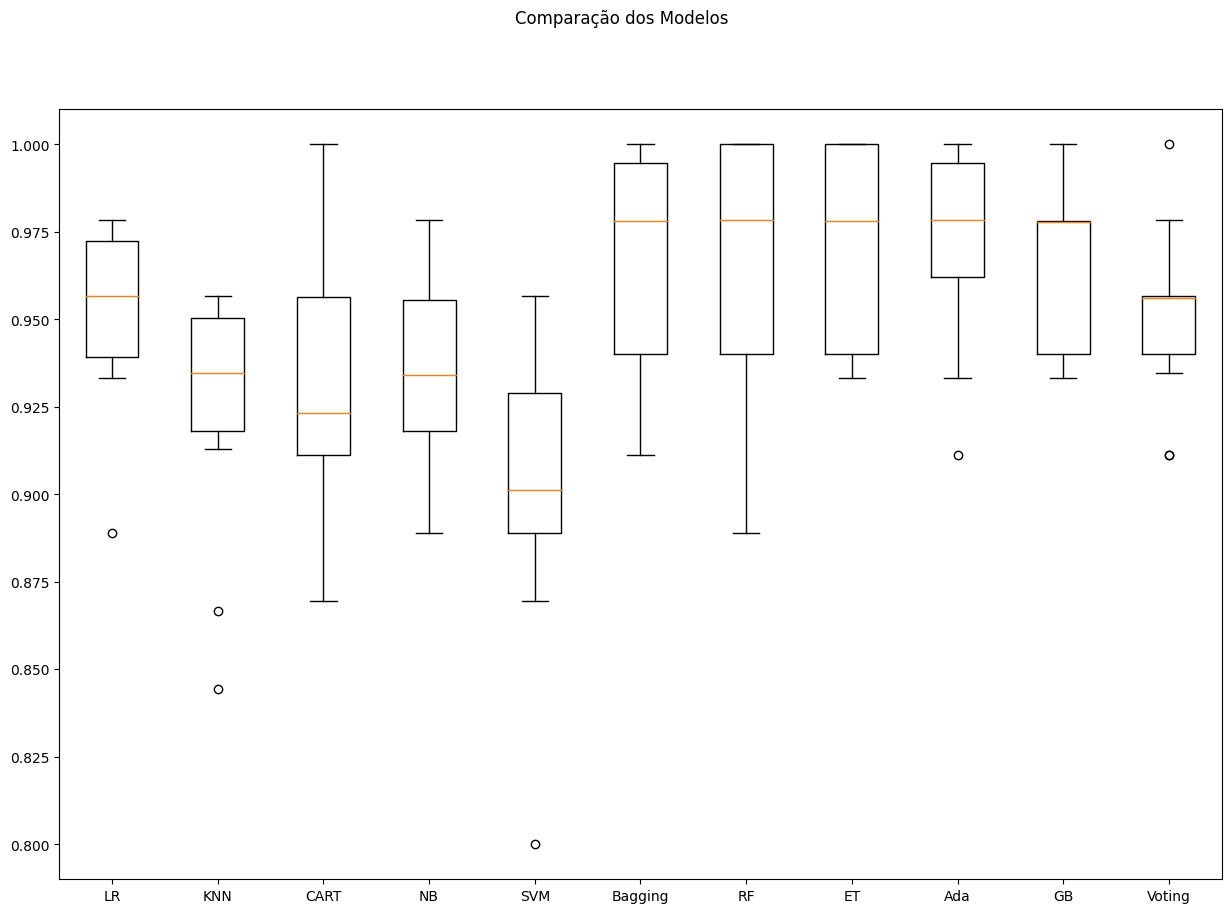

In [25]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

Em seguida, vamos repetir esse processo, utilizando a biblioteca Pipeline para criar e avaliar os modelos através da validação cruzada com os dados padronizados e normalizados (evitando o data leakage) e comparar o seu resultado com os modelos treinados com o dataset original:

LR-orig: 0.952 (0.026)
KNN-orig: 0.923 (0.036)
CART-orig: 0.932 (0.038)
NB-orig: 0.934 (0.028)
SVM-orig: 0.899 (0.041)
Bag-orig: 0.967 (0.030)
RF-orig: 0.967 (0.036)
ET-orig: 0.971 (0.028)
Ada-orig: 0.971 (0.028)
GB-orig: 0.967 (0.025)
Vot-orig: 0.952 (0.026)
LR-padr: 0.982 (0.022)
KNN-padr: 0.965 (0.024)
CART-padr: 0.932 (0.033)
NB-padr: 0.932 (0.030)
SVM-padr: 0.976 (0.015)
Bag-padr: 0.965 (0.028)
RF-padr: 0.969 (0.033)
ET-padr: 0.974 (0.024)
Ada-padr: 0.971 (0.028)
GB-padr: 0.965 (0.024)
Vot-padr: 0.976 (0.021)
LR-norm: 0.963 (0.028)
KNN-norm: 0.967 (0.028)
CART-norm: 0.936 (0.036)
NB-norm: 0.932 (0.030)
SVM-norm: 0.976 (0.021)
Bag-norm: 0.971 (0.024)
RF-norm: 0.963 (0.040)
ET-norm: 0.971 (0.030)
Ada-norm: 0.971 (0.028)
GB-norm: 0.965 (0.024)
Vot-norm: 0.974 (0.027)


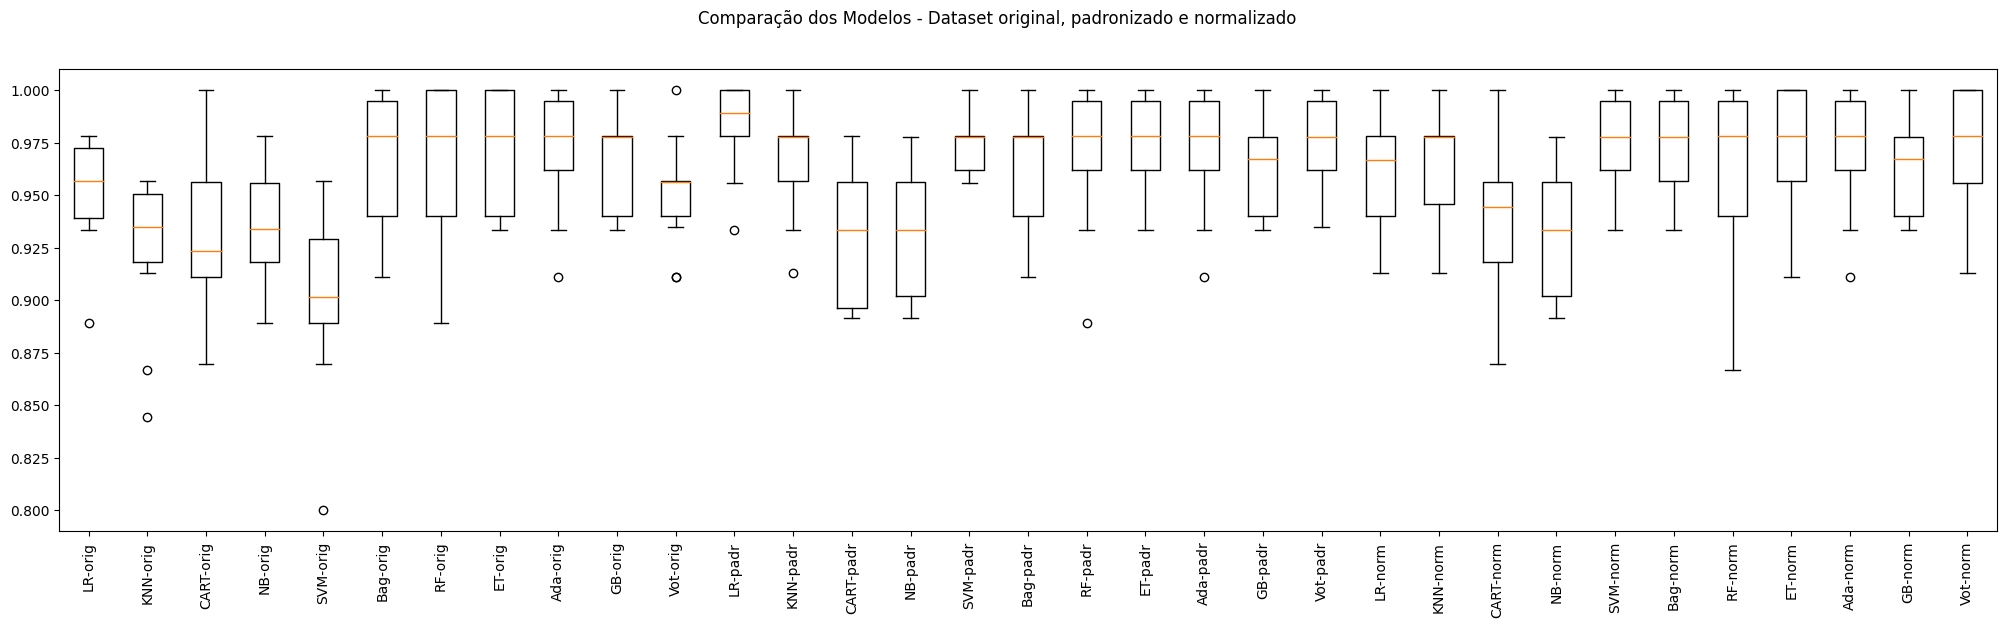

In [26]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Analisando os resultados, verificamos que, considerando a acurácia média, o modelo treinado com Regressão Logística através da validação cruzada com os dados padronizados apresentou os melhores resultados (98% de acurácia média e desvio-padrão de 2%), indicando que possivelmente seguiríamos com ele como escolha de algoritmo. Nesse caso, construiremos um novo modelo, treinado com toda a base de treino.

### Otimização dos hiperparâmetros

Agora iremos utilizar a biblioteca Grid Search para executar a otimização dos hiperparâmetros do algoritmo KNN, a título de exemplificação, a fim de buscar resultados ainda melhores para este algoritmo. Para tal, tentaremos todos os valores ímpares de k entre 1 e 21 e diferentes métricas de distância. Você pode experimentar também fazer a otimização de outros algoritmos para verificar se é possível encontrar uma configuração de modelo que supere os melhores resultados até o momento.

In [15]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.931739 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-padr - Melhor: 0.969275 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}
Sem tratamento de missings: knn-norm - Melhor: 0.971449 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 15}


Conseguimos melhorar a acurácia do algoritmo KNN para o dataset original, padronizado e normalizado, mas seguiremos com a Regressão Logistica com os dados padronizados que ainda teve acurácia melhor.

## 4 - Finalização do Modelo

Vamos agora finalizar o modelo escolhido com o que alcançou os melhores resultados que foi a regressão logística com os dados padronizados. A seguir, finalizaremos esse modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada), e faremos predições para o conjunto de dados de teste que foi separado logo no início da prática, a fim de confirmarmos os resultados. Primeiro, iremos realizar a padronização dos dados de entrada. Depois, treinaremos o modelo e exibiremos a acurácia de teste.

In [16]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9649122807017544


Por meio do conjunto de teste, verificamos que alcançamos acurácia de 96,5% em dados não vistos. Esse resultado foi bastante próximo da nossa avaliação anterior da regressão logística, que alcançou acurácia média de 98%. Valores semelhantes à acurácia de teste são esperados quando esse modelo estiver executando em produção e fazendo predições para novos dados.

Vamos agora preparar o modelo para utilização em produção. Para isso, vamos treiná-lo com todo o dataset, e não apenas o conjunto de treino.

In [17]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(x) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(x) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

LogisticRegression(max_iter=200)

## 5- Simulando a aplicação do modelo em dados não vistos

Finalmente, iremos simular a aplicação do modelo em dados não vistos, imaginando uma nova instância, mas que não sabemos a classe de saída. Poderemos, então, aplicar nosso modelo recém-treinado para fazer a predição da classe. Para tal, será necessário antes padronizar os dados utilizando a mesma escala dos dados usados no treinamento do modelo:

In [18]:
# Novos dados - não sabemos a classe!
data = {'mean_radius':[17.99],
'mean_texture':[10.38],
'mean_perimeter':[122.8],
'mean_area':[1001],
'mean_smoothness':[0.1184],
'mean_compactness':[0.2776],
'mean_concavity':[0.3001],
'mean_concave_points':[0.1471],
'mean_symmetry':[0.2419],
'mean_fractal_dimension':[0.07871],
'radius_error':[1.095],
'texture_error':[0.9053],
'perimeter_error':[8.589],
'area_error':[153.4],
'smoothness_error':[0.006399],
'compactness_error':[0.04904],
'concavity_error':[0.05373],
'concave_points_error':[0.01587],
'symmetry_error':[0.03003],
'fractal_dimension_error':[0.006193],
'worst_radius':[25.38],
'worst_texture':[17.33],
'worst_perimeter':[184.6],
'worst_area':[2019],
'worst_smoothness':[0.1622],
'worst_compactness':[0.6656],
'worst_concavity':[0.7119],
'worst_concave points':[0.2654],
'worst_symmetry':[0.4601],
'worst_fractal dimension':[0.1189],
        }

atributos = ['mean_radius',
'mean_texture',
'mean_perimeter',
'mean_area',
'mean_smoothness',
'mean_compactness',
'mean_concavity',
'mean_concave_points',
'mean_symmetry',
'mean_fractal_dimension',
'radius_error',
'texture_error',
'perimeter_error',
'area_error',
'smoothness_error',
'compactness_error',
'concavity_error',
'concave_points_error',
'symmetry_error',
'fractal_dimension_error',
'worst_radius',
'worst_texture',
'worst_perimeter',
'worst_area',
'worst_smoothness',
'worst_compactness',
'worst_concavity',
'worst_concave points',
'worst_symmetry',
'worst_fractal dimension']

entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:30].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

ValueError: X has 30 features, but StandardScaler is expecting 4 features as input.

Podemos agora realizar a predição das classes para os novos dados:

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0.]
